In [2]:
!pip install torch torchvision

### Pytorch Advantages vs Tensorflow
- Pytorch Enables dynamic computational graphs (which change be changed) while Tensorflow is static. 
- Tensorflow enables easier deployment. 

In [3]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import copy


In [4]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=50  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=100
args['cuda']=False


In [5]:
class BoostingDataset(Dataset):
    """Transforms dataset to boosting dataset."""

    def __init__(self, dataset):
        self.dataset = dataset
        self.n_used = np.zeros(len(dataset))
        self.loss = np.zeros(len(dataset))
        self.apply_boosting = False
        self.last_idx = []

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.apply_boosting:
            # compute idx
            # e.g. always take max loss idx
            idx = np.argmax(self.loss)
            self.loss[idx] = self.loss.min()
        self.last_idx.append(idx)
        self.n_used[idx] += 1
        return idx, self.dataset[idx]

    def loss_feedback(self, idx, loss):
        self.loss[idx] = loss
        self.last_idx = []


In [6]:
def get_train_loader():
    return torch.utils.data.DataLoader(
      BoostingDataset(datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))),
      batch_size=args['batch_size'], shuffle=True, **kwargs)

train_loader_for_testing = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities. 
        return F.log_softmax(x, dim=1)


In [8]:
def train(epoch, dataloader, boosting=False):
    model.train()
    dataloader.dataset.apply_boosting = boosting
    total_loss = 0
    total_n = 0
    for batch_idx, (idx, (data, target)) in enumerate(dataloader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss_tensor = F.nll_loss(output, target, reduction='none')
        loss = loss_tensor.mean()
        #dloss/dx for every Variable
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()

        dataloader.dataset.loss_feedback(idx, loss_tensor.detach().numpy())
        total_loss += loss_tensor.sum().item()
        total_n += loss_tensor.shape[0]
        #Print out the loss periodically. 
        if (batch_idx+1) % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * len(data), len(dataloader.dataset),
                100. * (batch_idx+1) / len(dataloader), loss.item()))
    total_loss /= total_n
    # print("Train loss", total_loss)
    return total_loss

def test(dataloader):
    model.eval()
    total_loss = 0
    total_n = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            if args['cuda']:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            loss_tensor = F.nll_loss(output, target, reduction='none')
            total_loss += loss_tensor.sum().item()
            total_n += loss_tensor.shape[0]
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    total_loss /= total_n
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        total_loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))
    return total_loss, correct / len(dataloader.dataset)



In [9]:
results = {'normal': {}, 'boosted': {}}
model_for_cloning = Net()
for boosting in [False, True]:
    boosting_tag = 'normal' if not boosting else 'boosted'
    train_loader = get_train_loader()
    model = copy.deepcopy(model_for_cloning)
    if args['cuda']:
        model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    train_losses = []
    test_losses = []
    train_accs, test_accs = [], []
    for epoch in range(1, args['epochs'] + 1):
        print("Epoch", epoch)
        train_loss = train(epoch, train_loader, boosting=boosting and epoch > 1)
        
        train_loss, train_acc = test(train_loader_for_testing)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        test_loss, test_acc = test(test_loader)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    results[boosting_tag]['dataloader'] = train_loader
    results[boosting_tag]['train_losses'] = train_losses
    results[boosting_tag]['test_losses'] = test_losses
    results[boosting_tag]['train_accs'] = train_accs
    results[boosting_tag]['test_accs'] = test_accs

Epoch 1


Average loss: 2.1972, Accuracy: 19454/60000 (32.42%)
Average loss: 2.1954, Accuracy: 3230/10000 (32.30%)
Epoch 2
Average loss: 1.5847, Accuracy: 44351/60000 (73.92%)
Average loss: 1.5725, Accuracy: 7469/10000 (74.69%)
Epoch 3
Average loss: 0.8004, Accuracy: 49957/60000 (83.26%)
Average loss: 0.7792, Accuracy: 8400/10000 (84.00%)
Epoch 4
Average loss: 0.5354, Accuracy: 52043/60000 (86.74%)
Average loss: 0.5151, Accuracy: 8741/10000 (87.41%)
Epoch 5
Average loss: 0.4189, Accuracy: 53421/60000 (89.04%)
Average loss: 0.3982, Accuracy: 8993/10000 (89.93%)
Epoch 6
Average loss: 0.3586, Accuracy: 54065/60000 (90.11%)
Average loss: 0.3381, Accuracy: 9094/10000 (90.94%)
Epoch 7
Average loss: 0.3165, Accuracy: 54731/60000 (91.22%)
Average loss: 0.2962, Accuracy: 9194/10000 (91.94%)
Epoch 8
Average loss: 0.2888, Accuracy: 55140/60000 (91.90%)
Average loss: 0.2682, Accuracy: 9273/10000 (92.73%)
Epoch 9
Average loss: 0.2696, Accuracy: 55379/60000 (92.30%)
Average loss: 0.2501, Accuracy: 9

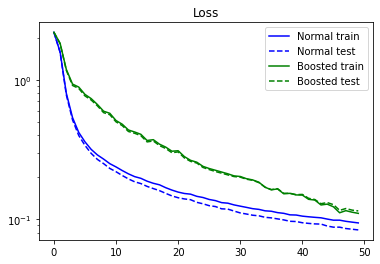

In [10]:
plt.title("Loss")
plt.plot(results['normal']["train_losses"], 'b-', label="Normal train")
plt.plot(results['normal']["test_losses"], "b--", label="Normal test")
plt.plot(results['boosted']["train_losses"], 'g-', label="Boosted train")
plt.plot(results['boosted']["test_losses"], "g--", label="Boosted test")
plt.yscale('log')
plt.legend()
plt.show()

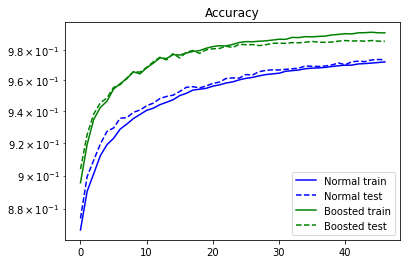

In [14]:
plt.title("Accuracy")
start = 3
plt.plot(results['normal']["train_accs"][start:], 'b-', label="Normal train")
plt.plot(results['normal']["test_accs"][start:], "b--", label="Normal test")
plt.plot(results['boosted']["train_accs"][start:], 'g-', label="Boosted train")
plt.plot(results['boosted']["test_accs"][start:], "g--", label="Boosted test")
plt.yscale('log')
plt.legend()
plt.show()

(array([5.8141e+04, 8.1300e+02, 3.8600e+02, 2.0200e+02, 1.4200e+02,
        1.2000e+02, 6.2000e+01, 5.7000e+01, 4.5000e+01, 3.2000e+01]),
 array([2.0000e+00, 2.8710e+02, 5.7220e+02, 8.5730e+02, 1.1424e+03,
        1.4275e+03, 1.7126e+03, 1.9977e+03, 2.2828e+03, 2.5679e+03,
        2.8530e+03]),
 <a list of 10 Patch objects>)

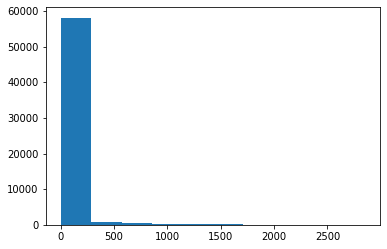

In [12]:
plt.hist(results['boosted']['dataloader'].dataset.n_used)

{'boxes': [<matplotlib.lines.Line2D at 0x7f847f16f320>],
 'caps': [<matplotlib.lines.Line2D at 0x7f847f16fd30>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f847f17a7f0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f847f17a470>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f847f16f630>,
  <matplotlib.lines.Line2D at 0x7f847f16f9b0>]}

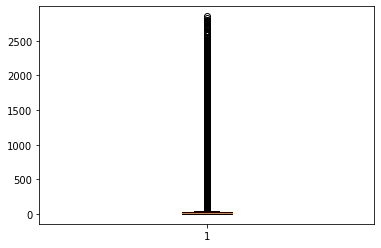

In [13]:
plt.boxplot(results['boosted']['dataloader'].dataset.n_used)